In [4]:
import pandas as pd
#import bamboolib
import os
import datetime
import numpy as np
from matplotlib import pyplot
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


## Chemins des fichiers

In [5]:
#a changer localement
aymeric = "/home/aymeric/python-scripts/anses_medialab/datas/" #aymeric
jp = 'd:/Projects/Medialab/Anses/' # Jean Philippe


path_base = aymeric
file_segmentation = f"{path_base}segmentation_common_freq.csv"

index=f"{path_base}index_alldefault_nameexhaustive_aymeric.csv"

all_corpus = f"{path_base}all_corpus_seg_with_sdhi_PI.csv"

#twittos = f"{path_base}tweets_pesticides/500_first_twittos_on_pesticides.csv"




path_base=''
file_segmentation = f"{path_base}segmentation_common_freq.csv"

index=f"{path_base}./indexation_results/index_alldefault_nameexhaustive_aymeric.csv"



## Chargement des données

In [6]:
#df0 = pd.read_csv(all_corpus, sep = "\t")
df_index = pd.read_csv(index, sep = "\t")
dfseg = pd.read_csv(file_segmentation, sep = "\t")

df_index['date'] = pd.to_datetime(df_index['date'], infer_datetime_format=True)
df_index['yearmonth']=(df_index['date'].dt.strftime('%Y-%m'))

df_index['date'] = df_index['date'].dt.date

## Fusion segment + indexation

In [7]:
segment = dfseg[["yearmonth", "segm", "origin"]]


df0 = df_index.merge(segment, how = "inner", on = ["origin", "yearmonth"])
df0["start_segment"] = df0.groupby(['origin','segm'])["date"].transform('min')
df0["end_segment"] = df0.groupby(['origin','segm'])["date"].transform('max')


## Bump Chart

In [8]:
def ranked_element(data, which, top_rank):
    """
    data = the dataframe
    which = a string ; the variable that we want to rank and display on bump chart
    top_rank = an integer ; the rank that values should reach at least one time to be part of bump chart
    """
    
    df = (
        data
          .value_counts(["origin", which, 'segm', 'start_segment'])
          .groupby(["origin", "segm"])
          .rank("first", ascending=False)
          .rename("rank")
          .sort_index()
          .reset_index()
         )
    
    if top_rank is not None :
        df.loc[df["rank"] > top_rank, f"top_rank_{top_rank}"] = 0
        df.loc[df["rank"] < top_rank, f"top_rank_{top_rank}"] = 1
        df["count_rank"] = df.groupby(["origin",which])[f"top_rank_{top_rank}"].transform("sum")
        df = df.loc[df["count_rank"] >= 1]
    else:
        pass
    
    ## Compute correlation matrix for each origin
    
    new_df0 = pd.DataFrame(columns=["term", 'cluster', 'origin']) 
    list_Z = []
    for x in df["origin"].unique():
        t = pd.pivot_table(df.loc[df["origin"] == x], 
                           index = "segm", columns = "term", 
                           values = "rank", fill_value=0)
        
        dissimilarity = 1 - abs(t.corr())
        
  
        Z = linkage(squareform(dissimilarity), 'complete') 
        list_Z.append(Z)
        threshold = 0.8
        labels = fcluster(Z, threshold, criterion='distance')
    
        name = [x for x in t.columns]
        cluster = [y for y in labels]
    
        new_df = pd.DataFrame(data = {"term": name, "cluster": cluster})
        new_df["origin"] = x
        new_df0 = pd.concat([new_df0, new_df], axis=0, ignore_index=True)
    
    
    df = df.merge(new_df0, how = "left", on = ["origin",which])
    
    
    
    
    return df, list_Z, new_df0
    


In [9]:
def bump_chart(data, which):
    
    """
    data = the dataframe
    """
    
    list_origin = ["media", "twitter", "facebook"]


    for n, x in enumerate(list_origin):
    
        df = data.loc[data["origin"]== x]
        n_top_ranked = 10
        top_sources = df[df["segm"] == df["segm"].max()].nsmallest(n_top_ranked, "rank")

        fig, ax = plt.subplots(figsize=(16, 10), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))
        
        fig.suptitle(x, fontsize=16)


        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(1))

        yax2 = ax.secondary_yaxis("right")
        yax2.yaxis.set_major_locator(FixedLocator(top_sources["rank"].to_list()))
        yax2.yaxis.set_major_formatter(FixedFormatter(top_sources[which].to_list()))


        for i, j in df.groupby([which]):
            ax = plt.plot("segm", "rank", "o-", data=j)
            

        plt.gca().invert_yaxis()
    
    return fig

In [10]:
def interactive_bump_chart(data, which, cluster):

    if cluster is None :
        pass
    else:
        data["cluster"] = pd.to_numeric(data["cluster"])
        data = data.loc[data["cluster"] == cluster]
        
    fig = px.line(data, x="start_segment", y="rank", color = which, facet_row="origin").update_traces(mode='markers+lines')
    fig['layout']['yaxis']['autorange'] = "reversed"

    fig.show()

In [117]:
df, Z, new_df0 = ranked_element(data = df0, which="term", top_rank= 25)

In [118]:
bump = interactive_bump_chart(data = df, which = "term", cluster = None)

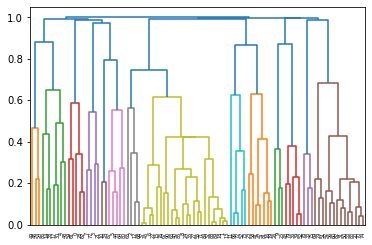

In [119]:
z = Z[1]
dendrogram(z, orientation='top');

## Matrice de corrélation

In [120]:
df3 = df.loc[df["origin"] == "facebook"]
df3['log-rank']=np.log(df3['rank'])
t = pd.pivot_table(df3, index = "segm", columns = "term", values = "rank", fill_value=0)

/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_15071/3407956100.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [121]:
#tl = pd.pivot_table(df3, index = "segm", columns = "term", values = "log-rank", fill_value=0)
#sns.clustermap(tl)

In [122]:
import scipy
rho_segment, pval_segment = scipy.stats.spearmanr(t,axis=1)
rho_terms, pval_terms = scipy.stats.spearmanr(t,axis=0)



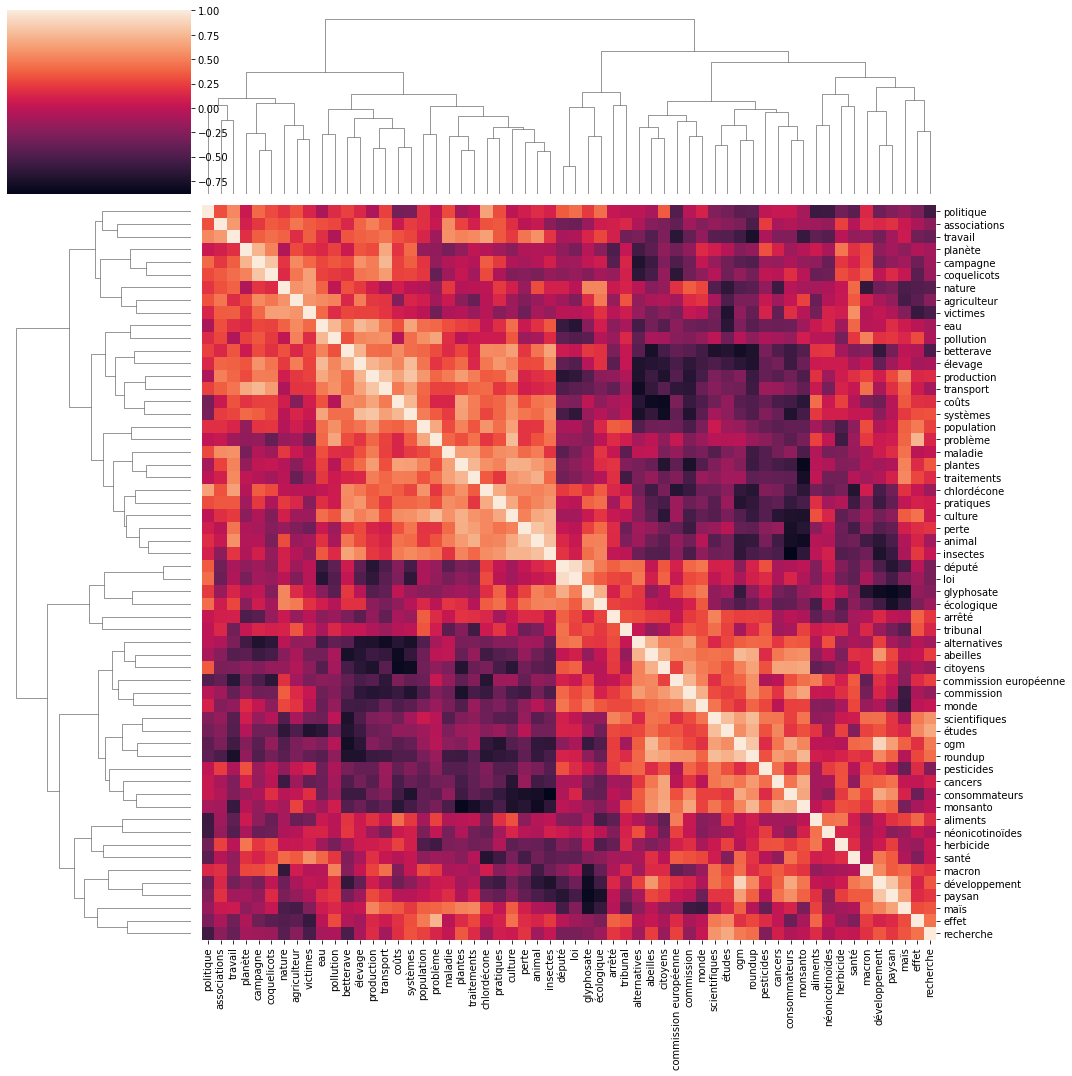

In [129]:
from matplotlib import pyplot as plt
#sns.clustermap(rho_terms)
ax=sns.clustermap(rho_terms,figsize=(15,15))#,labels=range(14))
new_labels=[]
labels_list=list(t.columns)
for l in ax.ax_heatmap.axes.get_xticklabels():
    l.set_text(labels_list[int(l.get_text())])
    new_labels.append(l)
ax.ax_heatmap.axes.set_yticklabels(new_labels,rotation=0)
ax.ax_heatmap.axes.set_xticklabels(new_labels,rotation = 90)
#ax.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.tight_layout()
plt.savefig('../images/clustermap_terms_pesticides.pdf')

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [42.5, 42.5, 72.5, 72.5],
  [12.5, 12.5, 57.5, 57.5],
  [95.0, 95.0, 105.0, 105.0],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [120.0, 120.0, 150.0, 150.0],
  [100.0, 100.0, 135.0, 135.0],
  [175.0, 175.0, 185.0, 185.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [225.0, 225.0, 235.0, 235.0],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [245.0, 245.0, 262.5, 262.5],
  [230.0, 230.0, 253.75, 253.75],
  [202.5, 202.5, 241.875, 241.875],
  [180.0, 180.0, 222.1875, 222.1875],
  [117.5, 117.5, 201.09375, 201.09375],
  [35.0, 35.0, 159.296875, 159.296875],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [325.0, 325.0, 335.0, 335.0],
  [300

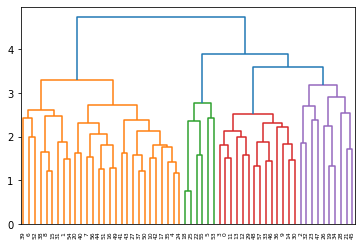

In [124]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage = (hc.linkage(sp.distance.pdist(rho_terms), method='average'))# for x in (t.values, rho_terms.values.T))
dendrogram(row_linkage)#, leaf_label_func=llf, leaf_rotation=90)


In [125]:
scipy.cluster.hierarchy.fcluster(row_linkage,t=4,criterion="distance")#,method='average')
#MR = maxRstat(Z, R, 3)
#scipy.cluster.hierarchy.fcluster(row_linkage,t=4,criterion="monocrit")#,method='average')
#fcluster(Z, t=0.8, criterion='monocrit', monocrit=MR)


array([2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2], dtype=int32)

In [126]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


In [127]:
cmap = sns.cm.rocket_r
sns.heatmap(cluster_corr(corrMatrix), cmap = cmap)

NameError: name 'corrMatrix' is not defined

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(24,10))
dissimilarity = 1 - abs(corrMatrix)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=t.columns, orientation='top');
